**Name:** *Muhammad Usman FAROOQ* and *Rohith*

**EID:** *mufarooq5* and

**Kaggle Team Name:** *Abelian Group*

At the end of the project turn it into a pip installable

# CS4487 - Course Project: Aerial Cactus Identification

## Goal
In this project, your goal is to train a classifier to predict whether an input image contains cactus.


## Methodology
You need to train classifiers using the training data, and then predict on the test data. You are free to choose the feature extraction method and classifier algorithm.  You are free to use methods that were not introduced in class.  You should probably do cross-validation to select a good parameters.


## Evaluation on Kaggle

You need to submit your test predictions to Kaggle for evaluation.  50% of the test data will be used to show your ranking on the live leaderboard.  After the assignment deadline, the remaining 50% will be used to calculate your final ranking. 

To submit to Kaggle you need to create an account, and use the competition invitation that will be posted on Canvas.

**Note:** You can only submit 2 times per day to Kaggle!



## Kaggle Notebooks

You can use Kaggle notebooks to run your code. This ipynb has also been uploaded to the Kaggle competition site. 

# Load the Data

The class labels `"1"` for images containing cactus and `"0"` for others.

To submit to Kaggle, you need to generate a Kaggle submission files, which is CSV file with the following format. `'id'` is the file name of the input image: 

<pre>
Id,Prediction
cactus_0181_18.jpg,1
Sinplanta.4365.jpg,0
...
</pre>

Here are two helpful functions for reading the data and writing the Kaggle submission file.

In [1]:
%matplotlib inline
import IPython.core.display         
# setup output image format (Chrome works best)
# IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
from glob import glob
from scipy import stats
import csv
import os

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import csv
import fnmatch
import os
from glob import glob
import matplotlib.pyplot as plt
plt.style.use("ggplot")
random.seed(100)

# OpenCV Image Library
import cv2
from PIL import Image as pilimg


# Create dataset folder
import shutil
import zipfile

# Import PyTorch
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision
import torch.optim as optim

torch.set_printoptions(linewidth=120)
torch.set_grad_enabled(True)  

In [2]:
def read_train_data():
    cactus_imgs = glob("training_set/cactus/*")
    cactus_labels = ones(len(cactus_imgs), dtype=int)
    nocactus_imgs = glob("training_set/no_cactus/*")
    nocactus_labels = zeros(len(nocactus_imgs), dtype=int)

    train_X = cactus_imgs + nocactus_imgs
    train_Y = hstack((cactus_labels, nocactus_labels))
    return train_X, train_Y

def read_test_data():
    return glob("validation_set/*/*")

def write_csv_kaggle_sub(fname, X, Y):
    # fname = file name
    # X is a list with image names
    # Y is a list/array with class entries
    
    # header
    tmp = [['Id', 'Prediction']]
    
    # add ID numbers for each Y
    for x,y in zip(X, Y):
        tmp2 = [x, y]
        tmp.append(tmp2)
        
    # write CSV file
    with open(fname, 'w') as f:
        writer = csv.writer(f)
        writer.writerows(tmp)

# YOUR CODE and DOCUMENTATION HERE

In [3]:
### CHECK AND PRINT STATEMENTS FOR READ DATA

train_X, train_Y = read_train_data()
print(train_X[0], train_Y[0])
print(train_X[15000], train_Y[15000])
print(len(train_X))

test_X = read_test_data()
print(test_X[0])
print(len(test_X))
print(os.path.basename(test_X[0]))

training_set/cactus\cactus_0028_0.jpg 1
training_set/no_cactus\Sinplanta.2677.jpg 0
17500
validation_set\cactus\cactus_0181_18.jpg
4000
cactus_0181_18.jpg


In [4]:
## Read the labels and names/paths of training images into a CSV
imageName = []
imageLabel = []
imagePath = []

for index, fileName in enumerate(train_X):
    if (fileName.startswith("training_set/cactus") or fileName.startswith("training_set/no_cactus")) and fileName.endswith(".jpg"):
        imageName.append(fileName.split("\\")[1])
        imageLabel.append(train_Y[index])
        imagePath.append(fileName)
            
print(len(imageName), len(imageLabel), len(set(imagePath)))

with open('training_set.csv', 'w') as f:
    writer = csv.writer(f)
    for i in range(len(imageLabel)):
        writer.writerow([imageName[i], imageLabel[i], imagePath[i]])

17500 17500 17500


In [5]:
## Read the labels and names/paths of test images into a CSV
imageName = []
imageLabel = []
imagePath = []

print(len(test_X))
for index, fileName in enumerate(test_X):
    if (fileName.startswith("validation_set\cactus") or fileName.startswith("validation_set\\cactus"))  and fileName.endswith(".jpg"):
        imageName.append(fileName.split("\\")[2])
        imageLabel.append(1)
        imagePath.append(fileName)
    elif (fileName.startswith("validation_set\no_cactus") or fileName.startswith("validation_set\\no_cactus")) and fileName.endswith(".jpg"):
        imageName.append(fileName.split("\\")[2])
        imageLabel.append(0)
        imagePath.append(fileName)
            
print(len(set(imageName)), len(imageLabel), len(set(imagePath)))
    
with open('validation_set.csv', 'w') as f:
    writer = csv.writer(f)
    for i in range(len(imageLabel)):
        writer.writerow([imageName[i], imageLabel[i], imagePath[i]])

4000
4000 4000 4000


In [6]:
## Turn CSVs into a Panda Dataframe

#hasCactus == 1 indicates that the image is a cactus, hasCactus == 0 indicate that the image is not a cactus
head = ['fileName','hasCactus', 'imagePath']
trainDF = pd.read_csv("training_set.csv", names = head, header = None)
testDF = pd.read_csv("validation_set.csv", names = head, header = None)

trainDF.head()

,fileName,hasCactus,imagePath
0,cactus_0028_0.jpg,1,training_set/cactus\cactus_0028_0.jpg
1,cactus_0028_1.jpg,1,training_set/cactus\cactus_0028_1.jpg
2,cactus_0028_10.jpg,1,training_set/cactus\cactus_0028_10.jpg
3,cactus_0028_101.jpg,1,training_set/cactus\cactus_0028_101.jpg
4,cactus_0028_104.jpg,1,training_set/cactus\cactus_0028_104.jpg


In [7]:
print("Training Size: {}".format(len(glob('training_set/*/*'))))
print("Validation Size: {}".format(len(glob('validation_set/*/*'))))

Training Size: 17500
Validation Size: 4000


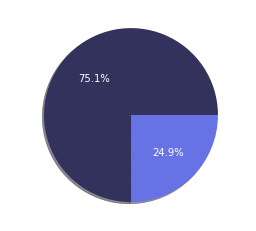

<Figure size 432x432 with 0 Axes>

In [8]:
# Counting the number of sample data for each class

%matplotlib inline
dataCount = trainDF.hasCactus.value_counts()
# TODO: CHOOSE SOME GOOD COLORS
plt.pie(dataCount, labels=['Has Cactus', 'No Cactus'], autopct='%1.1f%%', colors=['#32325d', '#6772e5'], textprops={'color': 'white'}, shadow=True) #e6ebf1, #87bbfd
plt.figure(figsize=(6,6))
plt.show()

In [9]:
# Statistics of the data
stats = trainDF.describe()
stats.head()

,hasCactus
count,17500.000000
mean,0.750629
std,0.432662
min,0.000000
25%,1.000000


# Setting up dataset/training data for Pytorch

In [10]:
# Data paths
trainingPath = 'training_set/'
validationPath = 'validation_set/'

In [11]:
# Our own custom class for datasets
class CreateDataset(Dataset):
    def __init__(self, data, dataDirectory = './', transform=None):
        super().__init__()
        self.DF = data.values
        self.data_dir = data.imagePath
        self.transform = transform

    def __len__(self):
        return len(self.DF)
    
    def __getitem__(self, index):
        img_name, label, imagePath = self.DF[index]
        image = cv2.imread(imagePath)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [12]:
#TODO: CHECK FOR NORMALIZ IF THESE MEAN AND STD GIVE BETTER RESULTS mean = [0.485, 0.456, 0.406]
# std = [0.229, 0.224, 0.225]

trainingTransforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((32,32)),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

OriginaltrainingTransforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


## original_train_data reflects the transform of the original paper where the problem was first introduced
original_train_data = CreateDataset(data=trainDF, dataDirectory=trainingPath, transform=OriginaltrainingTransforms)
## train_data reflects the dataset with the custom transforms and augmentation that we have
## introduced to solve the problem
train_data = CreateDataset(data=trainDF, dataDirectory=trainingPath, transform=trainingTransforms)

In [13]:
# Set Batch Size
batch_size = 64

# Percentage of training set to use as validation
valid_size = 0.2

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_index, valid_index = indices[split:], indices[:split]

# Create Samplers
train_sampler = SubsetRandomSampler(train_index)
valid_sampler = SubsetRandomSampler(valid_index)

# prepare data loaders (combine dataset and sampler)
train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)

In [14]:
transforms_test = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# creating test data
test_data = CreateDataset(data=testDF, dataDirectory=validationPath, transform=transforms_test)

# prepare the test loader
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [15]:
classes = [ 'No Cactus','Has Cactus']

In [16]:
def imshow(img):
    '''Helper function to un-normalize and display an image'''
    # unnormalize
    img = img / 2 + 0.5
    # convert from Tensor image and display
    plt.imshow(np.transpose(img, (1, 2, 0)))

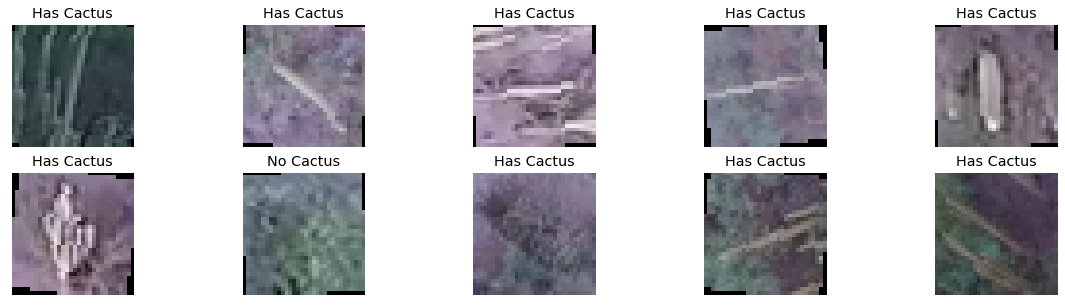

In [17]:
%matplotlib inline
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 5))
# display 10 unnormalized images
for index in np.arange(10):
    ax = fig.add_subplot(2, 10/2, index+1, xticks=[], yticks=[])
    imshow(images[index])
    ax.set_title(classes[labels[index]])

The cactus images have three dimensions for their RGB values and all these three color dimensions are used in CNN model to extract features hence we will visualize and plot the color channels here to have a better view of the cactus images. 

To get a better idea about how these three color channels represent information and how they vary in their channel value distribution we also look at the normalized RGB color channels as three separate grayscale intensity images.

Each little square in the  second visualization represents pixels with normalized values. Hence, larger values indicate a brighter pixel and smaller values indicate a dark pixel. 


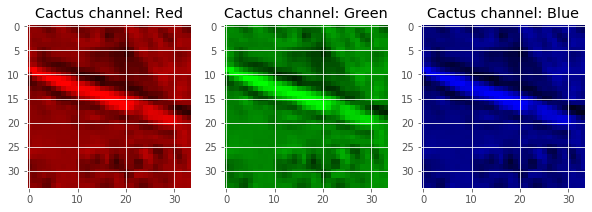

In [20]:
from PIL import Image as pilimg

cacti = trainDF[trainDF.hasCactus==1].sample(n=3, random_state=42)
cactus_img = np.array(pilimg.open(cacti.iloc[2, 2]))
fig = plt.figure(1, figsize=(10, 10))
channels = ['Red', 'Green', 'Blue']
for i in range(3):
    ax = fig.add_subplot(1, 3, i+1)
    temp = np.zeros(cactus_img.shape, dtype='uint8')
    temp[:,:,i] = cactus_img[:,:,i]
    ax.imshow(temp)
    plt.title("Cactus channel: " + channels[i])
plt.show()

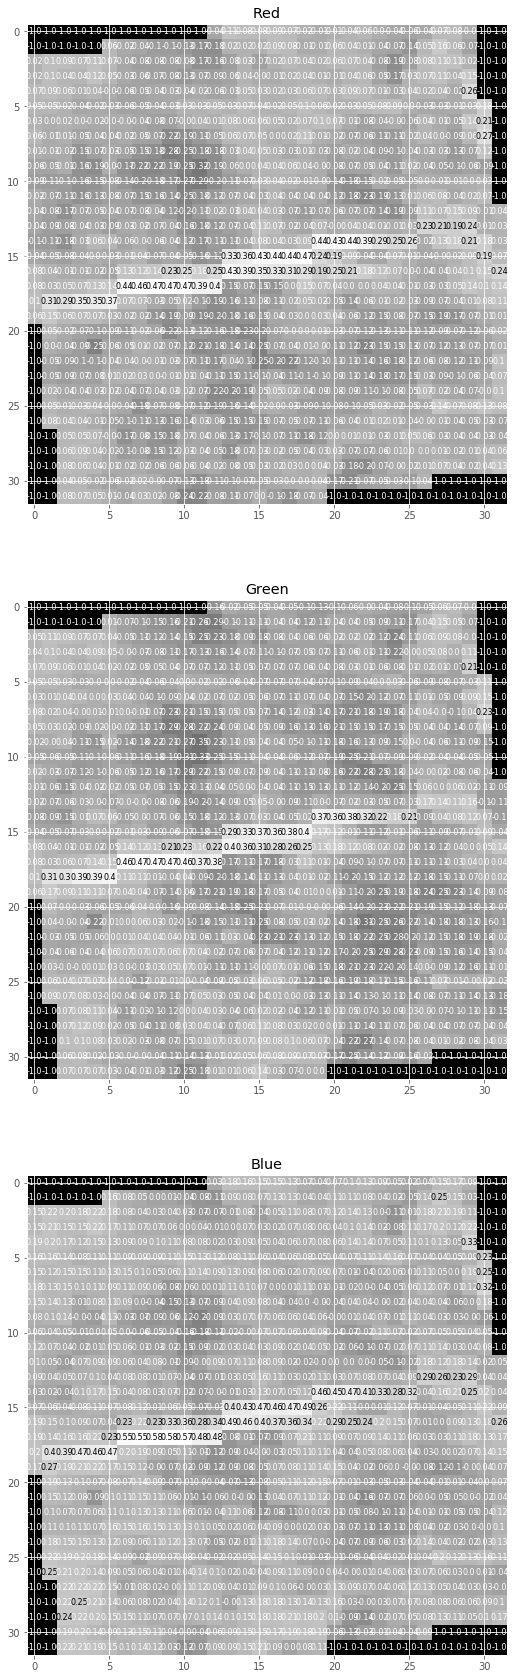

In [22]:
%matplotlib inline

rgb_img = np.squeeze(images[3])
channels = ['Red', 'Green', 'Blue']

fig = plt.figure(figsize = (30, 30)) 
for index in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(3, 1, index + 1)
    img = rgb_img[index]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[index])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

# CNN - Paper

In [23]:
### https://github.com/bollakarthikeya/LeNet-5-PyTorch/blob/master/lenet5_cpu.py
### 

class LeNet5CNN(nn.Module):
    def __init__(self):
        super(LeNet5CNN, self).__init__()
        # Convolution (In LeNet-5, 32x32 images are given as input. Hence padding of 2 is done below)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1)
        # Max-pooling
        self.max_pool_1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Convolution
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1)
        # Max-pooling
        self.max_pool_2 = nn.MaxPool2d(kernel_size=2)
        # Fully connected layer
        self.fc1 = nn.Linear(16*5*5, 120)   # convert matrix with 16*5*5 (= 400) features to a matrix of 120 features (columns)
        self.fc2 = nn.Linear(120, 84)       # convert matrix with 120 features to a matrix of 84 features (columns)
        self.fc3 = nn.Linear(84, 2)        # convert matrix with 84 features to a matrix of 2 features (columns)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))  
        # max-pooling with 2x2 grid
        x = self.max_pool_1(x)
        # convolve, then perform ReLU non-linearity
        x = F.relu(self.conv2(x))
        # max-pooling with 2x2 grid
        x = self.max_pool_2(x)
        # first flatten 'max_pool_2_out' to contain 16*5*5 columns
        x = x.view(-1, 16*5*5)
        # FC-1, then perform ReLU non-linearity
        x = torch.nn.functional.relu(self.fc1(x))
        # FC-2, then perform ReLU non-linearity
        x = torch.nn.functional.relu(self.fc2(x))
        # FC-3
        x = self.fc3(x)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return x, logits, probs

In [24]:
class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()
        # Convolutional Layer (sees 32x32x3 image tensor) 
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        # Convolutional Layer (sees 16x16x16 image tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # Convolutional Layer (sees 8x8x32 image tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # Convolutional Layer (sees 4*4*64 image tensor)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        # Maxpooling Layer
        self.pool = nn.MaxPool2d(2, 2)
        # Linear Fully-Connected Layer 1 (sees 2*2*128 image tensor)
        self.fc1 = nn.Linear(128*2*2, 512)
        # Linear FC Layer 2
        self.fc2 = nn.Linear(512, 2)
        # Set Dropout
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        # flatten image input
        x = x.view(-1, 128 * 2 * 2)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        return x

In [26]:
# Create an original model
originalModel = LeNet5CNN()
print(originalModel)

LeNet5CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (max_pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (max_pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)


In [27]:
# create a Improved Training CNN
model = ImprovedCNN()
print(model)

ImprovedCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


# Training our CNNs

In [ ]:
# specify the loss function
criterion = nn.CrossEntropyLoss()

# specify the optimizer
optimizer = optim.Adamax(model.parameters(), lr=0.001) ###TODO: lr = 3e-02

In [ ]:
epochs = 30

for epoch in range(epochs):
    for index , (images,labels) in enumerate(train_loader):
        
        
        pred = model(images)
        loss = criterion(pred, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print('Epoch: {}/{}, Loss: {}'.format(epoch+1, epochs, loss.item()))

In [ ]:
train_batch_loss_history = []
train_batch_accuracy_history = []

train_loss_history = []
train_accuracy_history = []

val_loss_history = []
val_accuracy_history = []

def validate(model, loss, optimizer):
        
    dataloader = val_dataloader
    model.eval()   # Set model to evaluate mode

    sum_loss = 0.
    sum_accuracy = 0.

    for inputs, labels in dataloader:
        inputs = inputs.cuda()
        labels = labels.cuda()

        optimizer.zero_grad()

        with torch.set_grad_enabled(False):
            preds = model(inputs)
            loss_value = loss(preds, labels)
            preds_class = preds.argmax(dim=1)

        sum_loss += loss_value.item()
        sum_accuracy += (preds_class == labels.data).float().mean().cpu().numpy().item()

    val_loss = sum_loss / len(dataloader)
    val_accuracy = sum_accuracy / len(dataloader)

    val_loss_history.append(val_loss)
    val_accuracy_history.append(val_accuracy)
    
    print(f'Validation accuracy {val_accuracy * 100:.2f} %, loss {val_loss:.4f}')

    model.train()  # Вернули как было


def train_model(model, loss, optimizer, scheduler, num_epochs):
        
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs-1}: ', end='')

        dataloader = train_dataloader
        model.train()  # Set model to training mode

        sum_loss = 0.
        sum_accuracy = 0.

        # Прогон по батчам
        for inputs, labels in dataloader:   #tqdm(dataloader):
            inputs = inputs.cuda()
            labels = labels.cuda()

            optimizer.zero_grad()

            # forward and backward
            with torch.set_grad_enabled(True):
                preds = model(inputs)
                loss_value = loss(preds, labels)
                preds_class = preds.argmax(dim=1)

                loss_value.backward()
                optimizer.step()
                # scheduler.step()

            batch_loss = loss_value.item()
            batch_accuracy = (preds_class == labels.data).float().mean().cpu().numpy().item()

            sum_loss += batch_loss
            sum_accuracy += batch_accuracy
            
            train_batch_loss_history.append(batch_loss)
            train_batch_accuracy_history.append(batch_accuracy)
            #print(f'\r----- {phase}, batch accuracy {train_batch_accuracy * 100:.2f} %, batch loss {train_batch_loss:.4f}')        
            #validate(model, loss, optimizer)
            
        epoch_loss = sum_loss / len(dataloader)
        epoch_acc = sum_accuracy / len(dataloader)

        train_loss_history.append(epoch_loss)
        train_accuracy_history.append(epoch_acc)
        scheduler.step()

        # Валидация
        # print('\n End epoch: ', end='')
        validate(model, loss, optimizer)
        
    return model

In [ ]:
%%time
# number of epochs to train the model
n_epochs = 30

# track change in validation loss
valid_loss_min = np.Inf 

# keeping track of losses as it happen
train_losses = []
valid_losses = []

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        pred = model(data)
        # calculate the batch loss
        loss = criterion(pred, target)
        # Predicted class
        preds_class = preds.argmax(dim=1)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        pred = model(data)
        # calculate the batch loss
        loss = criterion(pred, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'best_model.pt')
        valid_loss_min = valid_loss

In [ ]:
## MODEL EVAL/TEST ACCURACY

model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:

        preds = model(images)
        _, predicted = torch.max(preds.data, 1)
        total += labels.size(0)
        correct += (labels == predicted).sum().item()
        
    print('Test Accuracy {} %'.format(100 * correct / total))

In [ ]:
# write your predictions on the test set
dummy_test_X = [os.path.basename(x) for x in test_X]
test_Y = random.randint(2, size=len(test_X))

write_csv_kaggle_sub("my_submission.csv", dummy_test_X, test_Y)